## SVM Results

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import re

with open('../src/backup.txt', 'r') as f:
    results = f.read()

results = results.replace(' ', '')
res_per_size = [x[0] for x in re.findall('(Averaged(.*?)(?=Datasetsize))', results)] + [results[-183:]]

train_recalls = []
train_precisions = []
train_f1s = []
test_recalls = []
test_precisions = []
test_f1s = []
lists = [train_recalls, train_precisions, train_f1s, test_recalls, test_precisions, test_f1s]

for x in res_per_size:
    res = re.findall('0[\.][0-9]*', x)
    for i, r in enumerate(res):
        lists[i].append(float(r))

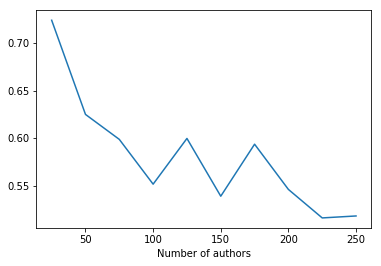

In [2]:
plt.plot(np.linspace(25,250,10),test_f1s)
plt.xlabel('Number of authors')
plt.show()

In [3]:
for i, f in enumerate(zip(train_f1s, test_f1s)):
    print('Dataset size:', (i+1)*25)
    print('Train F1:', f[0])
    print('Test F1:', f[1])
    print('')

Dataset size: 25
Train F1: 0.7437381951381952
Test F1: 0.723849

Dataset size: 50
Train F1: 0.6443196581196581
Test F1: 0.624906

Dataset size: 75
Train F1: 0.5613884577754547
Test F1: 0.598677

Dataset size: 100
Train F1: 0.531714848713378
Test F1: 0.551632

Dataset size: 125
Train F1: 0.5733988233988235
Test F1: 0.599662

Dataset size: 150
Train F1: 0.5317856976356976
Test F1: 0.538971

Dataset size: 175
Train F1: 0.5556018188161044
Test F1: 0.593614

Dataset size: 200
Train F1: 0.5368430014430015
Test F1: 0.5461

Dataset size: 225
Train F1: 0.5053265536932204
Test F1: 0.516163

Dataset size: 250
Train F1: 0.5035317369386719
Test F1: 0.518212



## XGBoost

In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.cross_validation import KFold
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
import xgboost as xgb
import pickle
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)

def one_hot(label, size):
    vec = np.zeros(int(size))
    vec[int(label)] = 1.
    return vec
    
data_path = '../data/preds/'

xgb_train_recalls = []
xgb_train_precisions = []
xgb_train_f1s = []
xgb_test_recalls = []
xgb_test_precisions = []
xgb_test_f1s = []
xgb_lists = [xgb_train_recalls, xgb_train_precisions, xgb_train_f1s, xgb_test_recalls, xgb_test_precisions, xgb_test_f1s]

for size in np.linspace(25,250,10):
    set_path = data_path + str(int(size)) + '/'
    
    X = []
    y = []
    X_test = []
    y_test = []
    for i in range(9):
        with open(set_path + 'train/preds_split' + str(i), 'rb') as f:
            X.append(pickle.load(f))
        with open(set_path + 'train/labels_split' + str(i), 'rb') as f:
            y.append(pickle.load(f))
    X = np.array([item for sublist in X for item in sublist])
    y = np.array([item for sublist in y for item in sublist])
    with open(set_path + 'test/preds9', 'rb') as f:
        X_test = pickle.load(f)
    with open(set_path + 'test/labels9', 'rb') as f:
        y_test = np.array(pickle.load(f))
    
    clf_xgb = xgb.XGBClassifier(objective = 'multi:softmax')
    param_dist = {'n_estimators': stats.randint(150, 500),
                  'learning_rate': stats.uniform(0.01, 0.07),
                  'subsample': stats.uniform(0.3, 0.7),
                  'max_depth': [3, 4, 5, 6, 7, 8, 9],
                  'colsample_bytree': stats.uniform(0.6, 0.45),
                  'min_child_weight': [1, 2, 3]
                 }
    clf = RandomizedSearchCV(clf_xgb, param_distributions = param_dist, n_iter = 17, scoring = 'f1_micro', error_score = 0, verbose = 3, n_jobs = -1)
    
    numFolds = 5
    folds = KFold(n = len(X), shuffle = True, n_folds = numFolds)
    
    estimators = []
    results = np.zeros(len(X))
    rec_score = 0.0
    prec_score = 0.0
    f_score = 0.0
    for train_index, valid_index in folds:
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        clf.fit(X_train, y_train)

        estimators.append(clf.best_estimator_)
        results[valid_index] = clf.predict(X_valid)
        rec_score += recall_score(y_valid, results[valid_index], average='micro')
        prec_score += precision_score(y_valid, results[valid_index], average='micro')
        f_score += f1_score(y_valid, results[valid_index], average='micro')
    rec_score /= numFolds
    prec_score /= numFolds
    f_score /= numFolds
    xgb_train_recalls.append(rec_score)
    xgb_train_precisions.append(prec_score)
    xgb_train_f1s.append(f_score)
    
    print('')
    print('##### Dataset size:', int(size))
    print('--- Train Scores ---')
    print('Recall:', rec_score)
    print('Precision:', prec_score)
    print('F1 score:', f_score)
    print('')
    
    preds = []
    for e in estimators:
        print(e.get_params())
        print('')
        preds.append(e.predict(X_test))
    votes = []
    for i in range(len(preds[0])):
        pred = [p[i] for p in preds]
        votes.append(max(set(pred), key=pred.count))
    votes = np.array(votes)
    rec_score = recall_score(y_test, votes, average='micro')
    prec_score = precision_score(y_test, votes, average='micro')
    f_score = f1_score(y_test, votes, average='micro')
    xgb_test_recalls.append(rec_score)
    xgb_test_precisions.append(prec_score)
    xgb_test_f1s.append(f_score)
    
    print('--- Test Scores ---')
    print('Recall:', rec_score)
    print('Precision:', prec_score)
    print('F1 score:', f_score)
    print('')

C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:   49.0s finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:   50.8s finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:   55.2s finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:   51.8s finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:   50.3s finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not emp


##### Dataset size: 25
--- Train Scores ---
Recall: 0.7266666666666668
Precision: 0.7266666666666668
F1 score: 0.7266666666666666

{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.016528730319883916, 'max_depth': 7, 'missing': None, 'colsample_bytree': 0.687576763459304, 'min_child_weight': 1, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.5376345191146203, 'n_estimators': 230, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}

{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.014580226888128107, 'max_depth': 5, 'missing': None, 'colsample_bytree': 0.8875472621888925, 'min_child_weight': 2, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.5927070529362783, 'n_estimators': 201, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread':

C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.03208107642079346, 'max_depth': 7, 'missing': None, 'colsample_bytree': 0.9468858391887901, 'min_child_weight': 3, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.535994361433825, 'n_estimators': 205, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}

{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.021871713627704625, 'max_depth': 5, 'missing': None, 'colsample_bytree': 0.6312441164890237, 'min_child_weight': 1, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.3080793442457701, 'n_estimators': 451, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


--- Test Scores ---
Recall: 0.728
Precision: 0.728
F1 score: 0.728

Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:  6.3min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:  6.3min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:  5.9min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:  5.5min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed:  6.3min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



##### Dataset size: 50
--- Train Scores ---
Recall: 0.6416666666666667
Precision: 0.6416666666666667
F1 score: 0.6416666666666667

{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.0344655872334792, 'max_depth': 5, 'missing': None, 'colsample_bytree': 0.9400145920144343, 'min_child_weight': 2, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.4057740440212211, 'n_estimators': 240, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.020071418077779776, 'max_depth': 9, 'missing': None, 'colsample_bytree': 0.8957714615404231, 'min_child_weight': 2, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.4879128566053883, 'n_estimators': 227, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.07201710205641687, 'max_depth': 4, 'missing': None, 'colsample_bytree': 0.7635320690902488, 'min_child_weight': 1, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.31645934548262705, 'n_estimators': 298, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.010515994891846365, 'max_depth': 8, 'missing': None, 'colsample_bytree': 0.9883599307360054, 'min_child_weight': 1, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.37429323711759255, 'n_estimators': 198, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.01890406506225216, 'max_depth': 8, 'missing': None, 'colsample_bytree': 0.9791550097454551, 'min_child_weight': 1, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.37224914607131754, 'n_estimators': 449, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


--- Test Scores ---
Recall: 0.648
Precision: 0.648
F1 score: 0.648

Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 14.2min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 18.2min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 16.9min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 12.2min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 13.5min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



##### Dataset size: 75
--- Train Scores ---
Recall: 0.5700000000000001
Precision: 0.5700000000000001
F1 score: 0.5700000000000001

{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.014267217149724946, 'max_depth': 8, 'missing': None, 'colsample_bytree': 0.9636961486182024, 'min_child_weight': 3, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.44726072030499253, 'n_estimators': 259, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.016676428735626348, 'max_depth': 4, 'missing': None, 'colsample_bytree': 0.8653571366589501, 'min_child_weight': 1, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.5782287070972649, 'n_estimators': 373, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.014445854363760948, 'max_depth': 7, 'missing': None, 'colsample_bytree': 0.87225305326961, 'min_child_weight': 3, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.6224936713994197, 'n_estimators': 251, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.022864077120313575, 'max_depth': 5, 'missing': None, 'colsample_bytree': 0.8606687928967075, 'min_child_weight': 1, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.4199709827100402, 'n_estimators': 205, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.026856604458871086, 'max_depth': 5, 'missing': None, 'colsample_bytree': 0.7502712267995948, 'min_child_weight': 2, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.42637427720912224, 'n_estimators': 364, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


--- Test Scores ---
Recall: 0.6266666666666667
Precision: 0.6266666666666667
F1 score: 0.6266666666666667

Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 15.0min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 51.0min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 43.6min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 38.6min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 41.9min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 37.1min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



##### Dataset size: 100
--- Train Scores ---
Recall: 0.5125
Precision: 0.5125
F1 score: 0.5125

{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.017791255060707358, 'max_depth': 5, 'missing': None, 'colsample_bytree': 0.9784418097807164, 'min_child_weight': 3, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.5978611300460737, 'n_estimators': 247, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.022876886069150226, 'max_depth': 7, 'missing': None, 'colsample_bytree': 0.8735737219102728, 'min_child_weight': 1, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.6699835809235779, 'n_estimators': 239, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.049290497891313664, 'max_depth': 8, 'missing': None, 'colsample_bytree': 0.8966993725401993, 'min_child_weight': 1, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.32943768180638816, 'n_estimators': 195, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.06790696859732619, 'max_depth': 3, 'missing': None, 'colsample_bytree': 0.8098536899153315, 'min_child_weight': 1, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.36560131193896805, 'n_estimators': 455, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.016380625069610848, 'max_depth': 6, 'missing': None, 'colsample_bytree': 0.7569736050495695, 'min_child_weight': 1, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.3812279212128759, 'n_estimators': 293, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


--- Test Scores ---
Recall: 0.56
Precision: 0.56
F1 score: 0.56

Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 81.8min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 81.1min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 32.4min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 88.5min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 33.6min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 90.4min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 30.0min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 95.9min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



##### Dataset size: 125
--- Train Scores ---
Recall: 0.5644444444444444
Precision: 0.5644444444444444
F1 score: 0.5644444444444444

{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.031990462490535, 'max_depth': 8, 'missing': None, 'colsample_bytree': 0.9614897902158807, 'min_child_weight': 1, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.5606349463434506, 'n_estimators': 267, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.010130476419541871, 'max_depth': 3, 'missing': None, 'colsample_bytree': 0.9008110174631943, 'min_child_weight': 2, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.8227001877853846, 'n_estimators': 443, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.04062897554363318, 'max_depth': 3, 'missing': None, 'colsample_bytree': 0.8307941395436349, 'min_child_weight': 1, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.4415782814043717, 'n_estimators': 158, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.014254752171383552, 'max_depth': 3, 'missing': None, 'colsample_bytree': 0.9694560256592999, 'min_child_weight': 2, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.6860350921209561, 'n_estimators': 397, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.04387493260219336, 'max_depth': 7, 'missing': None, 'colsample_bytree': 0.775062147196266, 'min_child_weight': 1, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.4142388500801619, 'n_estimators': 224, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


--- Test Scores ---
Recall: 0.6048
Precision: 0.6048
F1 score: 0.6048

Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 57.0min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 169.7min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 41.2min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 133.8min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 64.7min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 160.6min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 45.0min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 127.9min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 126.5min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



##### Dataset size: 150
--- Train Scores ---
Recall: 0.5392592592592592
Precision: 0.5392592592592592
F1 score: 0.5392592592592592

{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.010056944916795664, 'max_depth': 6, 'missing': None, 'colsample_bytree': 0.6350487864963332, 'min_child_weight': 2, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.6378259688806085, 'n_estimators': 499, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.025756810293750654, 'max_depth': 6, 'missing': None, 'colsample_bytree': 0.8689889725546441, 'min_child_weight': 2, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.435667606415079, 'n_estimators': 232, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.02577172057155879, 'max_depth': 4, 'missing': None, 'colsample_bytree': 0.780234171568769, 'min_child_weight': 1, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.5765799523975753, 'n_estimators': 453, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.023343424982045058, 'max_depth': 6, 'missing': None, 'colsample_bytree': 0.9041222481068021, 'min_child_weight': 2, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.36720522553293744, 'n_estimators': 448, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.03281824857243469, 'max_depth': 3, 'missing': None, 'colsample_bytree': 0.9762726314496579, 'min_child_weight': 1, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.345371953056404, 'n_estimators': 282, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


--- Test Scores ---
Recall: 0.5586666666666666
Precision: 0.5586666666666666
F1 score: 0.5586666666666666

Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 52.7min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 195.0min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 55.1min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 190.3min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 98.3min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 221.4min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 75.3min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 199.0min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 61.7min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 207.8min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



##### Dataset size: 175
--- Train Scores ---
Recall: 0.552063492063492
Precision: 0.552063492063492
F1 score: 0.552063492063492

{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.012792281575922656, 'max_depth': 8, 'missing': None, 'colsample_bytree': 0.971415125617265, 'min_child_weight': 2, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.5712307202249747, 'n_estimators': 433, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.025719795828787716, 'max_depth': 5, 'missing': None, 'colsample_bytree': 0.9267271557462041, 'min_child_weight': 2, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.6457234398769626, 'n_estimators': 367, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.021988883955611736, 'max_depth': 8, 'missing': None, 'colsample_bytree': 0.9715922963128467, 'min_child_weight': 1, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.3559746798125136, 'n_estimators': 216, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.024954630708975925, 'max_depth': 9, 'missing': None, 'colsample_bytree': 0.9401034058742163, 'min_child_weight': 1, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.36203304569437267, 'n_estimators': 434, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.01859253123503813, 'max_depth': 5, 'missing': None, 'colsample_bytree': 0.6440241198250803, 'min_child_weight': 2, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.6115091809132752, 'n_estimators': 207, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


--- Test Scores ---
Recall: 0.6062857142857143
Precision: 0.6062857142857143
F1 score: 0.6062857142857143

Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 117.2min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 307.5min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 166.0min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 479.5min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 136.7min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 327.4min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 123.9min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 349.3min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 124.5min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 321.9min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



##### Dataset size: 200
--- Train Scores ---
Recall: 0.5163888888888889
Precision: 0.5163888888888889
F1 score: 0.5163888888888889

{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.021299833974468642, 'max_depth': 3, 'missing': None, 'colsample_bytree': 0.7219842426340903, 'min_child_weight': 2, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.7288450049265263, 'n_estimators': 194, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.05183485666488996, 'max_depth': 5, 'missing': None, 'colsample_bytree': 0.7860938439263685, 'min_child_weight': 1, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.31938134650716415, 'n_estimators': 165, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.03210946804939611, 'max_depth': 4, 'missing': None, 'colsample_bytree': 0.8269141058234739, 'min_child_weight': 1, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.49650533503975103, 'n_estimators': 158, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.03140528773861325, 'max_depth': 7, 'missing': None, 'colsample_bytree': 0.9494573080097136, 'min_child_weight': 1, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.6213021193993518, 'n_estimators': 492, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'colsample_bylevel': 1, 'max_delta_step': 0, 'gamma': 0, 'booster': 'gbtree', 'learning_rate': 0.01105492758614463, 'max_depth': 8, 'missing': None, 'colsample_bytree': 0.8997979448778999, 'min_child_weight': 2, 'random_state': 0, 'seed': None, 'silent': True, 'subsample': 0.6996536896293963, 'n_estimators': 153, 'reg_lambda': 1, 'n_jobs': 1, 'scale_pos_weight': 1, 'reg_alpha': 0, 'base_score': 0.5, 'nthread': None, 'objective': 'multi:softprob'}



C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


--- Test Scores ---
Recall: 0.552
Precision: 0.552
F1 score: 0.552

Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 174.3min
[Parallel(n_jobs=-1)]: Done  51 out of  51 | elapsed: 454.8min finished
C:\Users\laure\Anaconda3\envs\neuralsnets\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Fitting 3 folds for each of 17 candidates, totalling 51 fits


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 153.6min


In [ ]:
with open('xgb_scores.pkl', 'wb+') as f:
    pickle.dump(xgb_lists, f)

In [73]:
preds = []
for e in estimators:
    preds.append(e.predict(X_test))
votes = []
for i in range(len(preds[0])):
    pred = [p[i] for p in preds]
    votes.append(max(set(pred), key=pred.count))
votes = np.array(votes)
print('##### Dataset size:', int(size))
print('--- Test Scores ---')
print('Recall:', recall_score(y_test, votes, average='micro'))
print('Precision:', precision_score(y_test, votes, average='micro'))
print('F1 score:', f1_score(y_test, votes, average='micro'))
print('')

##### Dataset size: 50
--- Test Scores ---
Recall: 0.638
Precision: 0.638
F1 score: 0.638

